### Control de instrumentos (26/04/2019)

Se carga la librería para el control de instrumentos y se crea un controlador de instrumentos (como si fuera un administrador de dispositivos, pero virtual). Luego se busca la lista de instrumentos reconocidos por la computadora como conectados y los iD de todos los instrumentos se almacenan en la variable ID.

In [3]:
import visa
rm = visa.ResourceManager()

ID=rm.list_resources()
print(ID)
#print(inst.query("*IDN?"))

('USB0::0x0699::0x0346::C033250::INSTR', 'USB0::0x0699::0x0363::C108013::INSTR')


In [4]:
print(type(rm))

<class 'pyvisa.highlevel.ResourceManager'>


Como están cargados el osciloscopio y el generador de funciones, la lista devolvió dos elementos. A continuación creamos dos objetos, correspondientes a cada uno de los elementos conectados.

In [5]:
osci = rm.open_resource(ID[1])
genf = rm.open_resource(ID[0])

In [6]:
print(type(genf))

<class 'pyvisa.resources.usb.USBInstrument'>


A continuación jugamos un poco con el comando "query" para extraer información del dispositivo. Este comando en realidad es una aplicación interna de los comandos "write" y "read". El programa manda un pedido de información y espera la respuesta. Luego utilizamos el comando "write", para setear propiedades del generador de funciones.

In [14]:
osci.query("WFMP:YMU?")

'8.0E-3\n'

In [7]:
genf.query("SOURce1:FREQuency:FIXed?")

'10.000000E0\n'

In [8]:
genf.write("SOURce1:FREQuency:FIXed 10")

(28, <StatusCode.success: 0>)

Luego viene la parte de la adquisición de datos. La experiencia consistió en generar una señal de forma y parámetros específicos con el generador de funciones, para luego observarla en la pantalla del osciloscopio y adquirir los datos a través de las funciones de la librería visa. La adquisición en ascii no funcionó; python daba un error. La que sí funcionó fue la adquisición de datos en binario. Sin embargo, si bien la forma de la función daba correctamente, los valores de los datos no tenían relación con lo que el osciloscopio mostraba en pantalla. 

Investigando un poco en el manual de tektronix encontramos algunos parámetros que pueden indicarse a la función "query_binary_values". 

In [9]:
osci.query("DATa?")

'RIB;REFA;CH1;1;2500;1\n'

In [4]:
import numpy as np
curve_in_dl = np.array(osci.query_binary_values('CURV?', datatype='b', is_big_endian=True))

In [5]:
import matplotlib.pyplot as plt

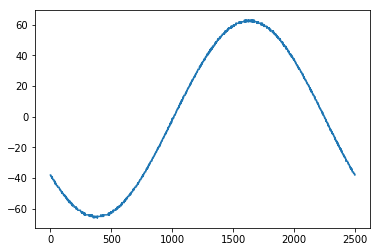

In [6]:
#plt.plot(np.divide(values,np.max(values)))
plt.plot(curve_in_dl)

In [15]:
osci.query("WFMP?")

'1;8;BIN;RI;MSB;2500;"Ch1, DC coupling, 5.0E-1 V/div, 1.0E-2 s/div, 2500 points, Sample mode";Y;4.0E-5;0;-5.0E-2;"s";2.0E-2;0.0E0;-1.0E0;"Volts"\n'

In [18]:
float(osci.query("WFMP:YOFF?"))

-1.0

In [7]:
YOFF_in_dl = float(osci.query("WFMP:YOFF?"))
YZERO_in_YUNits = float(osci.query("WFMP:YZERO?"))
YMUlt = float(osci.query("WFMP:YMULT?"))
YUNits = ((curve_in_dl - YOFF_in_dl)*YMUlt)+YZERO_in_YUNits

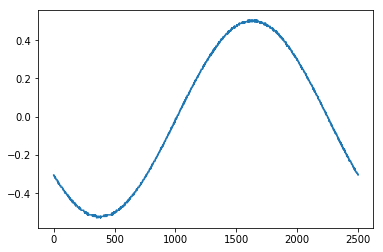

In [8]:
plt.plot(YUNits)

Waveform Data Formats

Internally, the oscilloscope uses one 8-bit data byte to represent each
waveform data point, regardless of the acquisition mode.
The DATa:WIDth command lets you specify the number of bytes per
data point when transferring data to and from an oscilloscope. This
provides compatibility with other digitizing oscilloscopes.

When DATa:WIDth is set to two:

 If sending data, the oscilloscope multiplies each point by 256; the
most significant byte then has meaningful data and the least
significant byte is 0

 If receiving data, the oscilloscope truncates the data (divides by
256) and saves the most significant byte

In [8]:
genf.query("SOURce1:VOLTage:LEVel:IMMediate:AMPLitude?")

'1.000E0\n'

In [9]:
genf.write("SOURce1:VOLTage:LEVel:IMMediate:AMPLitude 0.3")

(47, <StatusCode.success: 0>)

In [13]:
genf.query("SOURce1:AM:INTernal:FUNCtion?")

VisaIOError: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.

In [14]:
genf.write("SOURce1:FUNCtion SQU")

(22, <StatusCode.success: 0>)